In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from tqdm import tqdm
import parse
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    import tensorflow as tf
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp
from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
flowdata = dp.readfile('../data/processed/flow.pkl')

# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
# ahu = ahu.drop(columns=['hwe', 'cwe'])

In [ ]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothbuildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [5]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, flow])

# rearranging columns
#df = df[['oat', 'orh', 'sat', 'Ghi', 'flow', 'totale']]

In [6]:
df.head()

,oat,orh,sat,hwe,cwe,totale,Ghi,flow
2018-07-12 13:55:00,89.554909,76.0,75.443275,0.0,35.590466,35.590466,872.0,43.108143
2018-07-12 14:00:00,89.863190,76.0,75.443275,0.0,33.027813,33.027813,866.0,45.760704
2018-07-12 14:05:00,89.863190,76.0,75.443275,0.0,31.769627,31.769627,859.0,45.840881
2018-07-12 14:10:00,90.484146,69.0,75.443275,0.0,34.195641,34.195641,848.0,43.372566
2018-07-12 14:15:00,90.826981,69.0,75.443275,0.0,31.082222,31.082222,836.0,38.218956


In [7]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.1
)

Finished 'dataframeplot' in 0.5647 secs


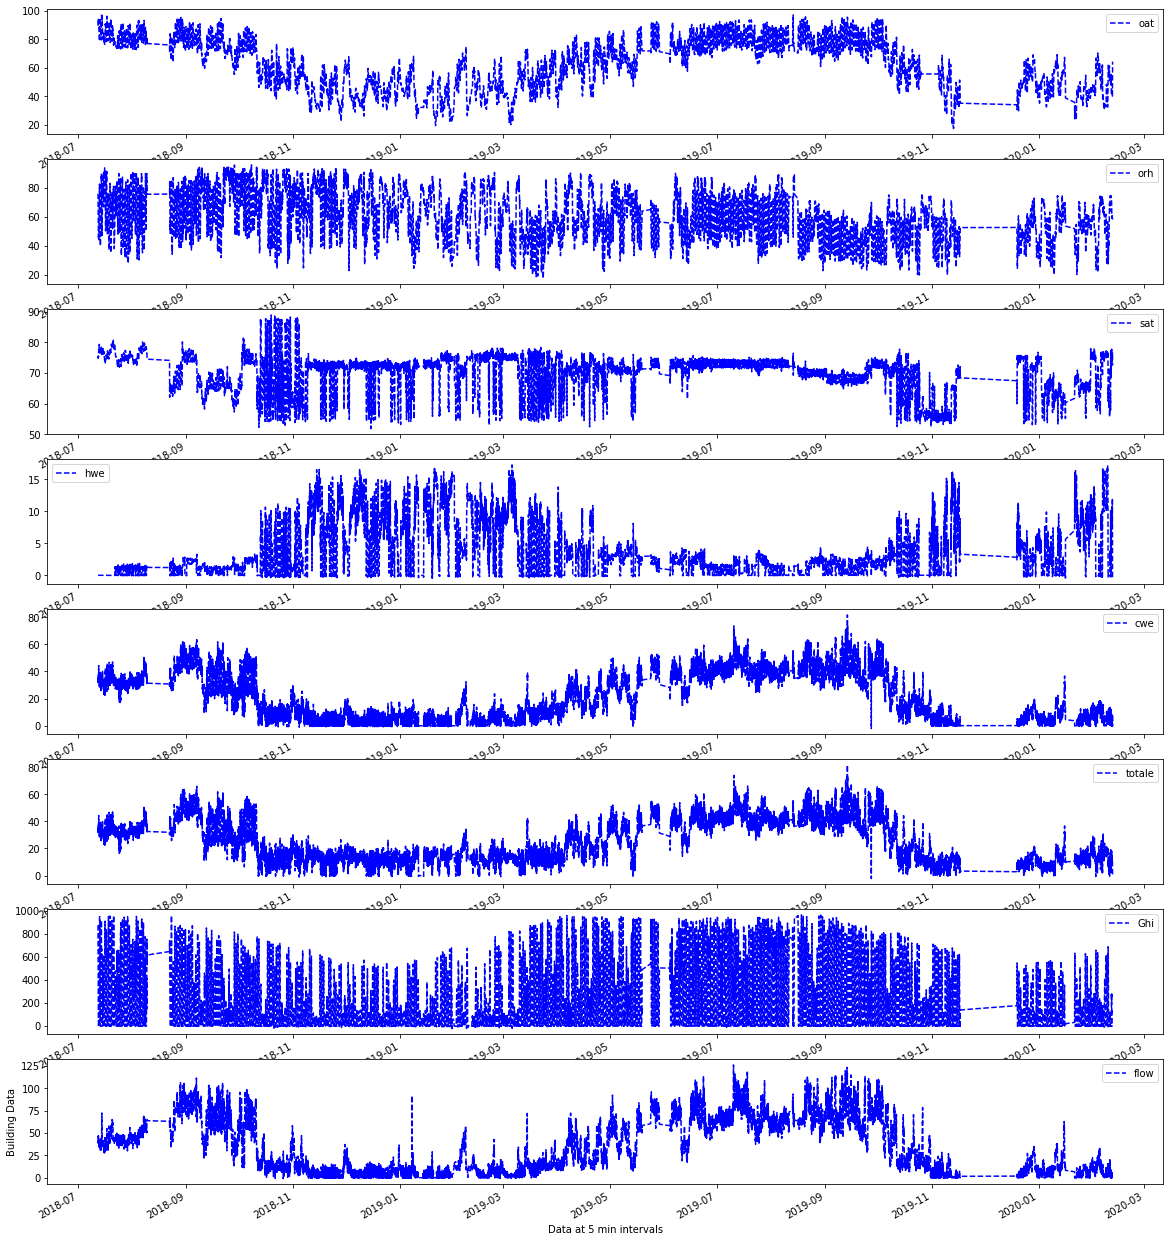

In [9]:
dp.dataframeplot(df=df_smoothed,
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [10]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df, subsequence=True, period=1, days=7, hours=0)

In [11]:
len(dflist)

10

In [ ]:
# dflist = [df]

In [12]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat', 'orh', 'sat', 'Ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [13]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [19]:
path = '../results/lstm2/'
!rm -rf ../results/lstm2

In [20]:
# create the results directory
try:
    os.mkdir(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        os.remove(path + f)
        
os.mkdir(path + 'loginfo')

In [21]:
try:
    del model
except NameError:
    pass

K.clear_session()

In [22]:
config = {
    'weeklist': weeklist,
    'lstm_hidden_units': 4,
    'lstm_no_layers': 2,
    'dense_hidden_units':8,
    'dense_no_layers': 2
}

modeldesigndone = False
initial_epoch = 0
for weekno, weekdata in enumerate(tqdm(config['weeklist'])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']

    if not modeldesigndone:
        #Instantiate learner model
        model = mp.lstm_model(path,
                              inputdim=X_train.shape[-1],
                              outputdim=y_train.shape[-1],
                              period=1)

        # Desing model architecture
        model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']] * config['lstm_no_layers'],
                           densehiddenlayers=[config['dense_hidden_units']] * config['dense_no_layers'],
                           dropoutlist=[[], []],
                           batchnormalizelist=[[], []])

        # creating early stopping and learning reate changing callbacks
        model.model_callbacks()

        modeldesigndone = True

    # train the model
    history = model.train_model(X_train, y_train, X_test, y_test, epochs=200, initial_epoch = initial_epoch)
    try:
        initial_epoch += len(history.history['loss'])
    except KeyError:
        pass

    # evaluate the model for metrics at this stage
    # see inside results folder to look at t
    # train and test plots as well as logged errors inside the text file
    preds_train, preds_test = model.evaluate_model(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   y_scaler,
                                                   scaling=True,
                                                   saveplot=True,
                                                   Week=weekno)

  0%|          | 0/10 [00:00<?, ?it/s]

Train on 1511 samples, validate on 504 samples
Epoch 1/200
 - 2s - loss: 736.0466 - val_loss: 733.9884
Epoch 2/200
 - 1s - loss: 726.9487 - val_loss: 721.0622
Epoch 3/200
 - 1s - loss: 708.0269 - val_loss: 693.2823
Epoch 4/200
 - 1s - loss: 669.0528 - val_loss: 639.6630
Epoch 5/200
 - 1s - loss: 598.5505 - val_loss: 547.9407
Epoch 6/200
 - 1s - loss: 485.2131 - val_loss: 410.5155
Epoch 7/200
 - 1s - loss: 335.6232 - val_loss: 254.9880
Epoch 8/200
 - 1s - loss: 196.2858 - val_loss: 133.4754
Epoch 9/200
 - 1s - loss: 105.6539 - val_loss: 71.7150
Epoch 10/200
 - 1s - loss: 68.7354 - val_loss: 52.0917
Epoch 11/200
 - 1s - loss: 58.6239 - val_loss: 47.4861
Epoch 12/200
 - 1s - loss: 56.2976 - val_loss: 46.4046
Epoch 13/200
 - 1s - loss: 55.5510 - val_loss: 46.0038
Epoch 14/200
 - 1s - loss: 55.1415 - val_loss: 45.7835
Epoch 15/200
 - 1s - loss: 54.8428 - val_loss: 45.6289
Epoch 16/200
 - 1s - loss: 54.5932 - val_loss: 45.5052
Epoch 17/200
 - 1s - loss: 54.3787 - val_loss: 45.4009
Epoch 18/2

 - 1s - loss: 48.9778 - val_loss: 44.0315
Epoch 149/200
 - 1s - loss: 48.9640 - val_loss: 44.0289
Epoch 150/200
 - 1s - loss: 48.9500 - val_loss: 44.0264
Epoch 151/200
 - 1s - loss: 48.9361 - val_loss: 44.0238
Epoch 152/200
 - 1s - loss: 48.9221 - val_loss: 44.0212
Epoch 153/200
 - 1s - loss: 48.9080 - val_loss: 44.0187
Epoch 154/200
 - 1s - loss: 48.8939 - val_loss: 44.0162
Epoch 155/200
 - 1s - loss: 48.8797 - val_loss: 44.0137
Epoch 156/200
 - 1s - loss: 48.8654 - val_loss: 44.0112
Epoch 157/200
 - 1s - loss: 48.8512 - val_loss: 44.0085
Epoch 158/200
 - 1s - loss: 48.8369 - val_loss: 44.0059
Epoch 159/200
 - 1s - loss: 48.8225 - val_loss: 44.0032
Epoch 160/200
 - 1s - loss: 48.8082 - val_loss: 44.0004
Epoch 161/200
 - 1s - loss: 48.7939 - val_loss: 43.9975
Epoch 162/200
 - 1s - loss: 48.7794 - val_loss: 43.9945
Epoch 163/200
 - 1s - loss: 48.7649 - val_loss: 43.9914
Epoch 164/200
 - 1s - loss: 48.7504 - val_loss: 43.9884
Epoch 165/200
 - 1s - loss: 48.7357 - val_loss: 43.9853
Epoch 

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
 10%|█         | 1/10 [04:32<40:54, 272.70s/it]

Train on 1511 samples, validate on 504 samples


 20%|██        | 2/10 [04:33<25:28, 191.10s/it]

Train on 1511 samples, validate on 504 samples


 30%|███       | 3/10 [04:34<15:37, 133.98s/it]

Train on 1511 samples, validate on 504 samples


 40%|████      | 4/10 [04:34<09:24, 94.01s/it] 

Train on 1511 samples, validate on 504 samples


 50%|█████     | 5/10 [04:35<05:30, 66.03s/it]

Train on 1511 samples, validate on 504 samples


 60%|██████    | 6/10 [04:36<03:05, 46.44s/it]

Train on 1511 samples, validate on 504 samples


 70%|███████   | 7/10 [04:37<01:38, 32.73s/it]

Train on 1511 samples, validate on 504 samples


 80%|████████  | 8/10 [04:37<00:46, 23.13s/it]

Train on 1511 samples, validate on 504 samples


 90%|█████████ | 9/10 [04:38<00:16, 16.41s/it]

Train on 1511 samples, validate on 504 samples


100%|██████████| 10/10 [04:39<00:00, 27.92s/it]


Name of the file:  ../results/lstm2/5min Results_File.txt


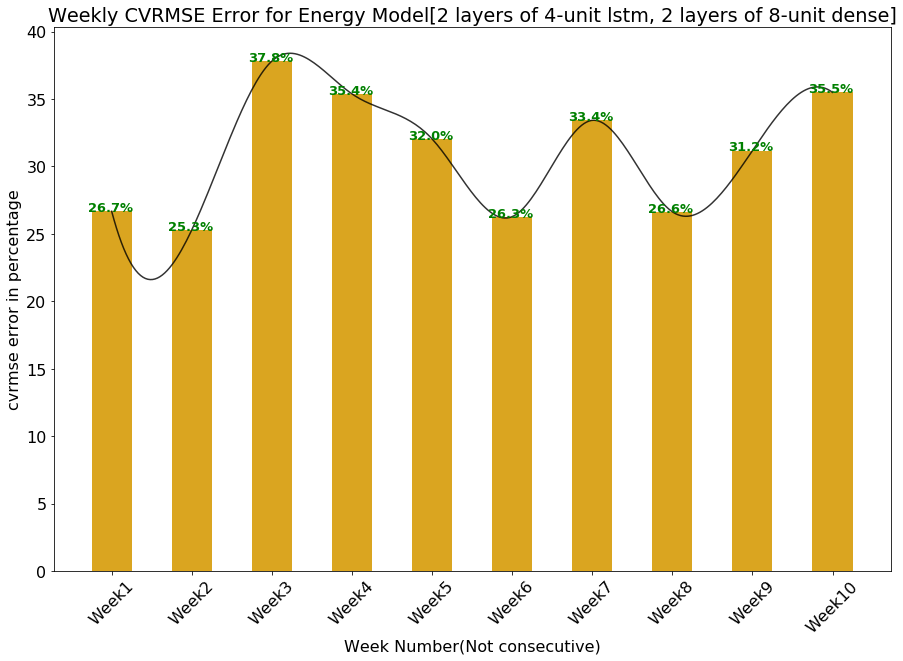

In [24]:
# Open a file
fo = open(path+"5min Results_File.txt", "r")
print ("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Week No:{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train':{'rmse': [], 'cvrmse' : [], 'mae' : []},
    'Test':{'rmse': [], 'cvrmse' : [], 'mae' : []}
}
for line in lines:
    p = parse.parse(parse_format,line)
    stats[p[2]]['rmse'].append(float(p[3]))
    stats[p[4]]['cvrmse'].append(float(p[5]))
    stats[p[6]]['mae'].append(float(p[7]))
          
fo.close()

# from dataprocess import plotutils as pu
plot_args = dict(
    bars = stats['Train']['cvrmse'],
    color = 'goldenrod',
    bar_label = 'cvrmse',
    saveloc = path,
    smoothcurve = True,
    bar_annotate = True,
    saveplot = True,
    xlabel = 'Week Number(Not consecutive)',
    ylabel = 'cvrmse error in percentage',
    title = 'Weekly CVRMSE Error for Energy Model[{} layers of {}-unit lstm, {} layers of {}-unit dense]'.format(config['lstm_no_layers'],config['lstm_hidden_units'], config['dense_no_layers'],config['dense_hidden_units']),
    xticktype = 'Week'
)
pu.single_bar_plot(
    **plot_args
)

In [ ]:
model.show_model()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '../results/lstmtrain/loginfo/' --port 8200

In [ ]:
dp.dataframeplot(dflist[2], lazy=False, style='-', legend=True)